In [707]:
import glob
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings 
warnings.filterwarnings("ignore")

In [708]:
dpath="/Users/prachibhatia/Desktop/delhi"
csv_files=glob.glob(os.path.join(dpath,"*.csv"))
df_list=[]

In [709]:
for file in csv_files:
    d = pd.read_csv(file)
    if 'From Date' in d.columns and 'To Date' in d.columns:
        d['From Date'] = pd.to_datetime(d['From Date'])
        d['To Date'] = pd.to_datetime(d['To Date'])
    else:
        print(f"Warning: 'From Date' or 'To Date' column missing in {file}")
        continue
    d['Date'] = d['From Date'].dt.date
    d['Time'] = d[['From Date', 'To Date']].min(axis=1).dt.strftime('%H:%M:%S')
    d['Date & Time'] = pd.to_datetime(d['Date'].astype(str) + ' ' + d['Time'])
    d = d.drop(columns=['From Date', 'To Date', 'Date', 'Time'])
    d['Date & Time'] = pd.to_datetime(d['Date & Time'])
    d.set_index('Date & Time', inplace=True)
    
    df_list.append(d)

tdf = pd.concat(df_list, axis=0, sort=False)
tdf = tdf.groupby(tdf.index).mean()

In [827]:
tdf = tdf.loc[:, :'Ozone (ug/m3)']

tdf.drop(columns=["NO (ug/m3)", "NOx (ppb)"], inplace=True)

tdf.index = pd.to_datetime(tdf.index) 
tdf=tdf.interpolate(method="time", axis=0)
tdf = tdf.apply(lambda x: x.fillna(x.median()) if x.isna().sum() > 0 else x)

In [711]:
mdf = tdf.resample('M').mean()

In [712]:
mdf.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO2 (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3)
Date & Time,,,,,,,
2010-01-31,94.219270,213.856801,43.992131,36.439947,8.491246,3.514159,20.515406
2010-02-28,97.866145,213.856801,50.588431,21.075729,9.561839,3.579543,22.078301
2010-03-31,103.993329,144.384086,35.846462,15.406269,17.059972,2.356449,33.640571
2010-04-30,76.536028,55.585540,42.156490,11.618321,16.914912,3.504549,45.058827
2010-05-31,113.707030,52.059767,45.619502,16.500134,14.628650,2.529773,49.354530


In [713]:
def calculate_sub_index(Cp, BLO, BHI, ILO, IHI):
    Ip = ((IHI - ILO) / (BHI - BLO)) * (Cp - BLO) + ILO
    return round(Ip, 2)

def get_breakpoints(pollutant, Cp):
    pollutant_breakpoints = {
        'PM10 (ug/m3)': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),
                 (251, 350, 201, 300), (351, 430, 301, 400), (430, float('inf'), 401, 500)],
        'PM2.5 (ug/m3)': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),
                  (91, 120, 201, 300), (121, 250, 301, 400), (250, float('inf'), 401, 500)],
        'NO2 (ug/m3)': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),
                (181, 280, 201, 300), (281, 400, 301, 400), (400, float('inf'), 401, 500)],
        'Ozone (ug/m3)': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),
               (169, 208, 201, 300), (209, 748, 301, 400), (748, float('inf'), 401, 500)],
        'CO (mg/m3)': [(0, 1.0, 0, 50), (1.1, 2.0, 51, 100), (2.1, 10, 101, 200),
               (10.1, 17, 201, 300), (17.1, 34, 301, 400), (34, float('inf'), 401, 500)],
        'SO2 (ug/m3)': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),
                (381, 800, 201, 300), (801, 1600, 301, 400), (1600, float('inf'), 401, 500)],
        'NH3 (ug/m3)': [(0, 200, 0, 50), (201, 400, 51, 100), (401, 800, 101, 200),
                (801, 1200, 201, 300), (1201, 1800, 301, 400), (1800, float('inf'), 401, 500)],
    }

    for BLO, BHI, ILO, IHI in pollutant_breakpoints.get(pollutant, []):
        if BLO <= Cp <= BHI:
            return {'BLO': BLO, 'BHI': BHI, 'ILO': ILO, 'IHI': IHI}
    
    BLO, BHI, ILO, IHI = pollutant_breakpoints.get(pollutant, [])[-1]
    return {'BLO': BLO, 'BHI': BHI, 'ILO': ILO, 'IHI': IHI}

def calculate_aqi_for_pollutant(pollutant, Cp):
    breakpoints = get_breakpoints(pollutant, Cp)
    return calculate_sub_index(Cp, **breakpoints)

def add_aqi_sub_indices_and_overall_aqi(mdf):
    sub_index_columns = []
    for pollutant in mdf.columns:
        if pollutant in ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO2 (ug/m3)', 'Ozone (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)', 'NH3 (ug/m3)']:
            sub_index_column = f'{pollutant}_sub_index'
            sub_index_columns.append(sub_index_column)
            mdf[sub_index_column] = mdf[pollutant].apply(lambda Cp: calculate_aqi_for_pollutant(pollutant, Cp))  
    mdf['AQI'] = mdf[sub_index_columns].max(axis=1)
    return mdf

mdf = add_aqi_sub_indices_and_overall_aqi(mdf)

mdf.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO2 (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),PM2.5 (ug/m3)_sub_index,PM10 (ug/m3)_sub_index,NO2 (ug/m3)_sub_index,NH3 (ug/m3)_sub_index,SO2 (ug/m3)_sub_index,CO (mg/m3)_sub_index,Ozone (ug/m3)_sub_index,AQI
Date & Time,,,,,,,,,,,,,,,
2010-01-31,94.219270,213.856801,43.992131,36.439947,8.491246,3.514159,20.515406,211.99,175.99,54.76,9.11,10.61,118.72,20.52,211.99
2010-02-28,97.866145,213.856801,50.588431,21.075729,9.561839,3.579543,22.078301,224.44,175.99,63.05,5.27,11.95,119.54,22.08,224.44
2010-03-31,103.993329,144.384086,35.846462,15.406269,17.059972,2.356449,33.640571,245.36,129.83,44.81,3.85,21.32,104.21,33.64,245.36
2010-04-30,76.536028,55.585540,42.156490,11.618321,16.914912,3.504549,45.058827,154.04,55.59,52.45,2.90,21.14,118.60,45.06,154.04
2010-05-31,113.707030,52.059767,45.619502,16.500134,14.628650,2.529773,49.354530,278.52,52.06,56.80,4.13,18.29,106.39,49.35,278.52


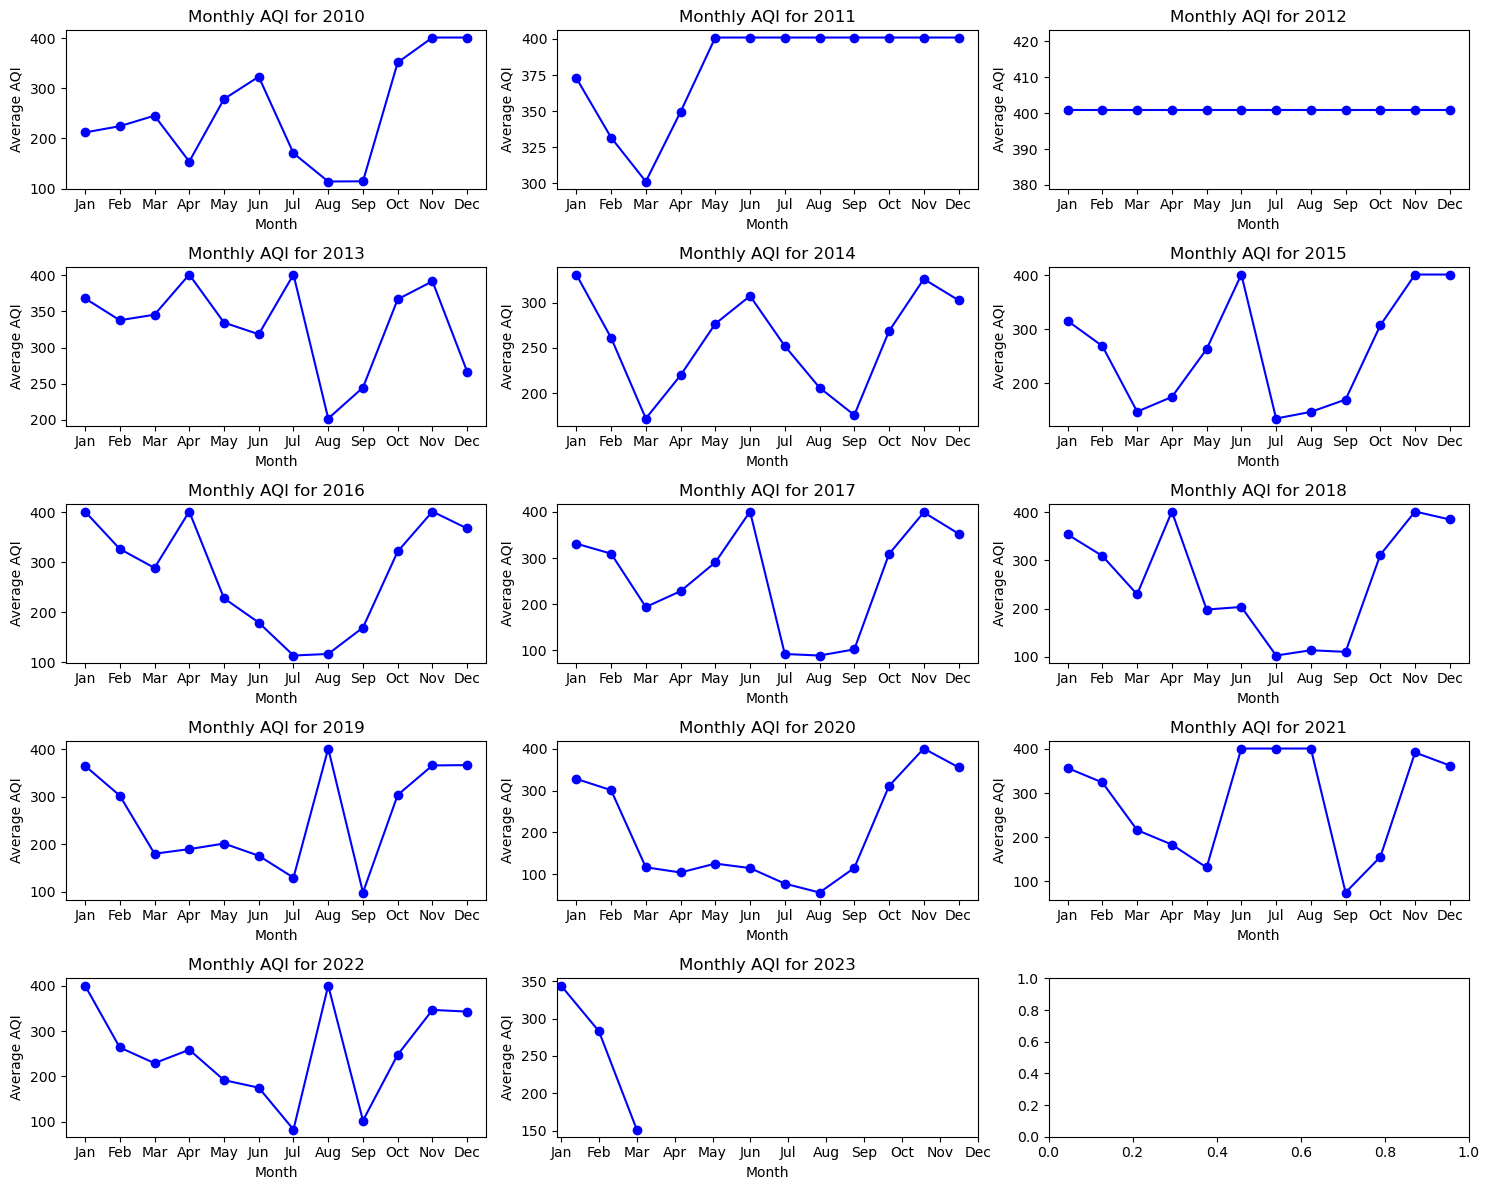

In [714]:
import matplotlib.pyplot as plt

mdf.index = pd.to_datetime(mdf.index)

mdf['Year'] = mdf.index.year
mdf['Month'] = mdf.index.month

monthly_aqi = mdf.groupby(['Year', 'Month'])['AQI'].mean().unstack()

years = range(2010, 2024)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
axes = axes.flatten() 

for i, year in enumerate(years):
    if year in monthly_aqi.index:
        axes[i].plot(monthly_aqi.columns, monthly_aqi.loc[year], marker='o', color='b')
        axes[i].set_title(f'Monthly AQI for {year}')
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Average AQI')
        axes[i].set_xticks(range(1, 13))
        axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

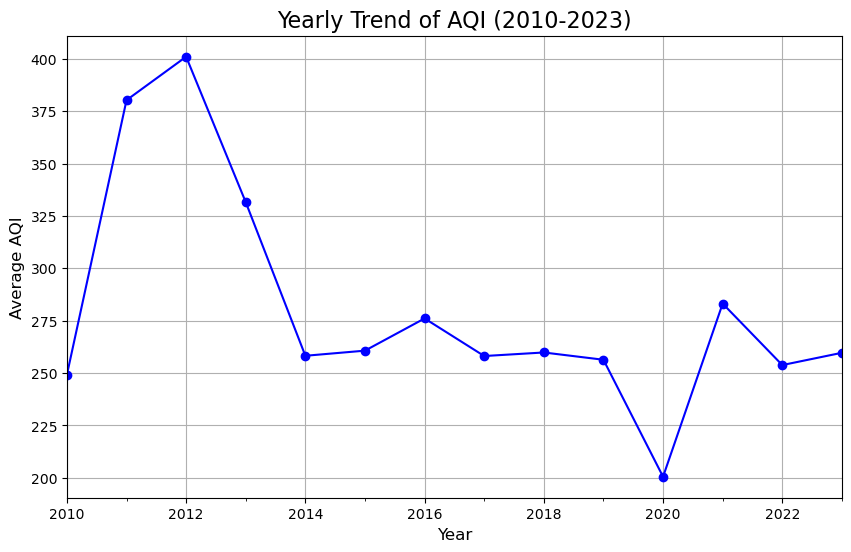

In [715]:
import pandas as pd
import matplotlib.pyplot as plt

ydf = mdf.resample('Y')['AQI'].mean()

plt.figure(figsize=(10, 6))
ydf.plot(kind='line', color='blue', marker='o')

plt.title('Yearly Trend of AQI (2010-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)

plt.grid(True)
plt.show()

In [716]:
from statsmodels.tsa.stattools import adfuller

def ad_test(data):
    data = data.dropna()  
    dftest = adfuller(data, autolag="AIC")
    
    print("ADF Statistic: ", dftest[0])
    print("P-value: ", dftest[1])
    print("Number of lags: ", dftest[2])
    print("Number of observations used for ADF Regression and Critical Values Calculation: ", dftest[3])
    print("Critical Values: ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)
    
    if dftest[1] < 0.05:
        print("The data is stationary (p-value < 0.05).")
    else:
        print("The data is not stationary (p-value >= 0.05).")
        
ad_test(mdf['AQI'])  

ADF Statistic:  -1.8132289231398675
P-value:  0.3739139606895808
Number of lags:  14
Number of observations used for ADF Regression and Critical Values Calculation:  144
Critical Values: 
	 1% :  -3.476597917537401
	 5% :  -2.8818291230495543
	 10% :  -2.5775887982253085
The data is not stationary (p-value >= 0.05).


In [717]:
mdf['AQI_diff'] = mdf['AQI'].diff().dropna()
ad_test(mdf['AQI_diff'])

ADF Statistic:  -4.109652103437126
P-value:  0.0009335501158161417
Number of lags:  13
Number of observations used for ADF Regression and Critical Values Calculation:  144
Critical Values: 
	 1% :  -3.476597917537401
	 5% :  -2.8818291230495543
	 10% :  -2.5775887982253085
The data is stationary (p-value < 0.05).


In [718]:
stepwise_fit = auto_arima(mdf["AQI"], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1916.084, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1912.014, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1908.443, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1914.086, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1888.343, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1886.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1906.443, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1881.321, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1879.796, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1910.016, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -933.939
Date:                Wed, 27 Nov 2024   AIC                           1877.877
Time:                        08:48:09   BIC                           1893.190
Sample:                    01-31-2010   HQIC                          1884.096
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4582      0.123     -3.734      0.000      -0.699      -0.218
ar.L2          0.5349      0.111      4.808      0.000       0.317       0.753
ma.L1          0.0041      0.080      0.052      0.959      -0.152       0.161
ma.L2         -0.9473      0.066    -14.269      0.000      -1.077      -0.817
sigma2      7854.6820   1145.566      6.857      0.000    5609.413    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.39   Prob(JB):                         0.51
Heteroskedasticity (H):               2.74   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [719]:
split_index = int(len(mdf) * 0.8)

train = mdf.iloc[:split_index]
test = mdf.iloc[split_index:]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (127, 18)
Test shape: (32, 18)


In [720]:
model=ARIMA(train["AQI"], order=(2,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                  127
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -734.656
Date:                Wed, 27 Nov 2024   AIC                           1479.311
Time:                        08:48:09   BIC                           1493.493
Sample:                    01-31-2010   HQIC                          1485.073
                         - 07-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3984      0.162     -2.455      0.014      -0.717      -0.080
ar.L2          0.5892      0.129      4.563      0.000       0.336       0.842
ma.L1          0.0068      0.131      0.052      0.958      -0.251       0.264
ma.L2         -0.9214      0.106     -8.725      0.000      -1.128      -0.714
sigma2      6694.3751   1015.394      6.593      0.000    4704.239    8684.511
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 3.50
Prob(Q):                              0.34   Prob(JB):                         0.17
Heteroskedasticity (H):               3.05   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [721]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start, end=end,typ="levels")
print(pred)

2020-08-31    166.162081
2020-09-30    163.559257
2020-10-31    216.979285
2020-11-30    194.162389
2020-12-31    234.729182
2021-01-31    205.122619
2021-02-28    240.821102
2021-03-31    209.153521
2021-04-30    242.804628
2021-05-31    210.738352
2021-06-30    243.341947
2021-07-31    211.458095
2021-08-31    243.371791
2021-09-30    211.870292
2021-10-31    243.225151
2021-11-30    212.171590
2021-12-31    243.018707
2022-01-31    212.431372
2022-02-28    242.793564
2022-03-31    212.674141
2022-04-30    242.564183
2022-05-31    212.908574
2022-06-30    242.335626
2022-07-31    213.137768
2022-08-31    242.109641
2022-09-30    213.362849
2022-10-31    241.886810
2022-11-30    213.584251
2022-12-31    241.667304
2023-01-31    213.802159
2023-02-28    241.451149
2023-03-31    214.016675
Freq: ME, Name: predicted_mean, dtype: float64


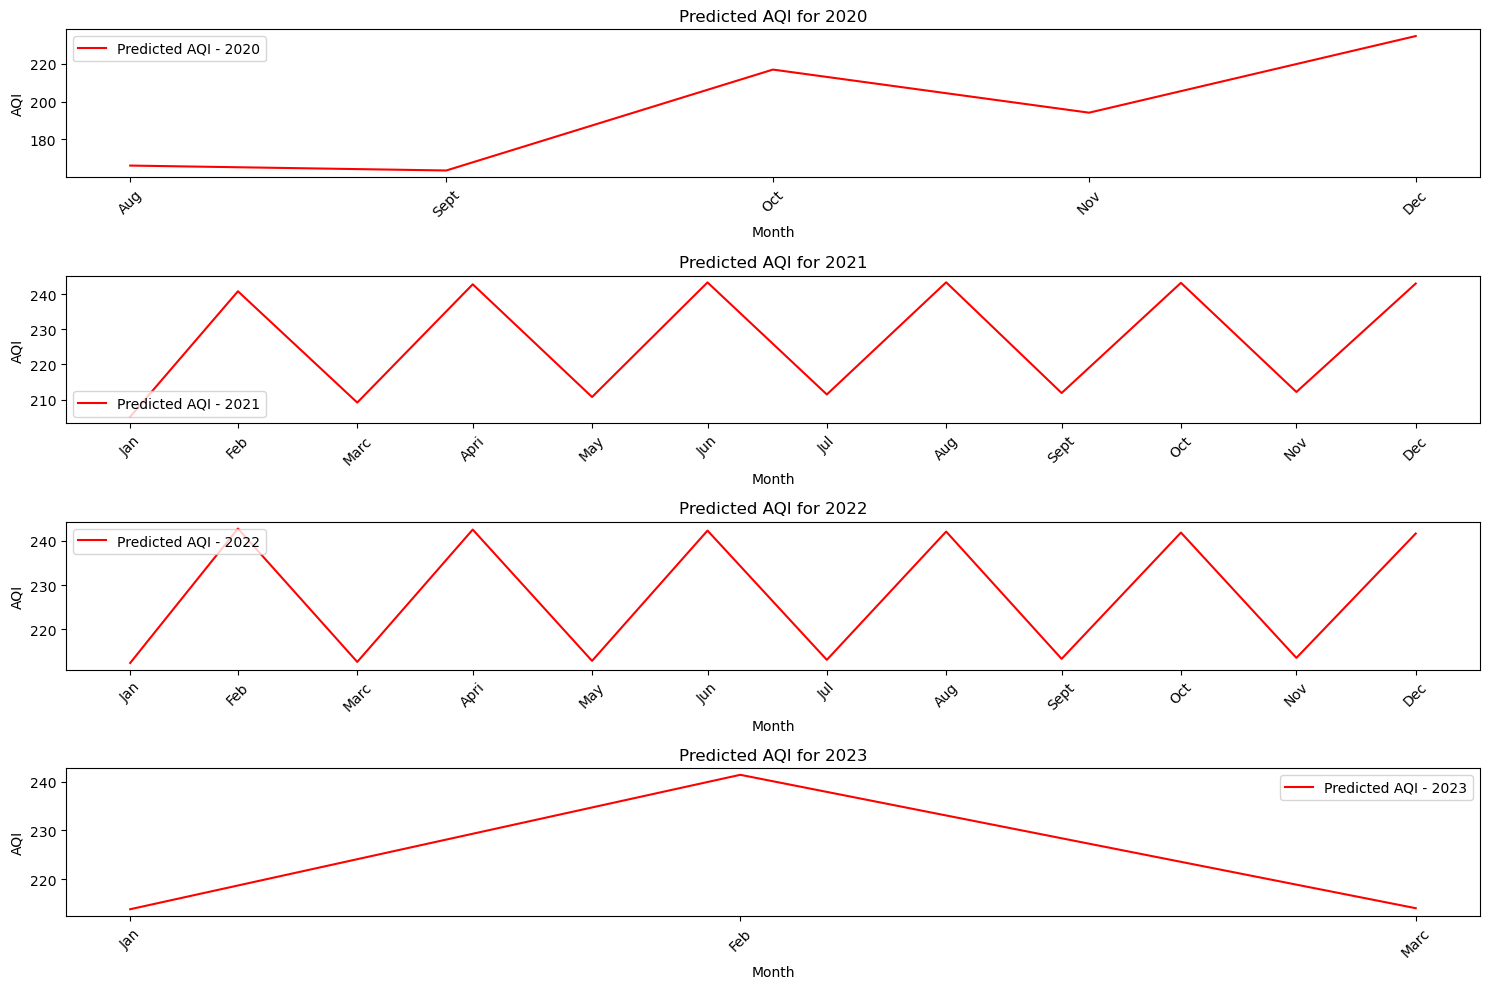

In [815]:
test['Year'] = test.index.year
test['Month'] = test.index.month

month_names = ['Jan', 'Feb', 'Marc', 'Apri', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(15, 10))
years = test['Year'].unique()

for i, year in enumerate(years, 1):
    year_test = test[test['Year'] == year]
    year_pred = pred[test.index.year == year]
    
    plt.subplot(len(years), 1, i)
    plt.plot(year_test.index, year_pred, label=f'Predicted AQI - {year}', color='red')
    plt.xticks(year_test.index, year_test['Month'].apply(lambda x: month_names[x-1]), rotation=45)
    plt.title(f'Predicted AQI for {year}')
    plt.xlabel('Month')
    plt.ylabel('AQI')
    plt.legend()


plt.tight_layout()
plt.show()

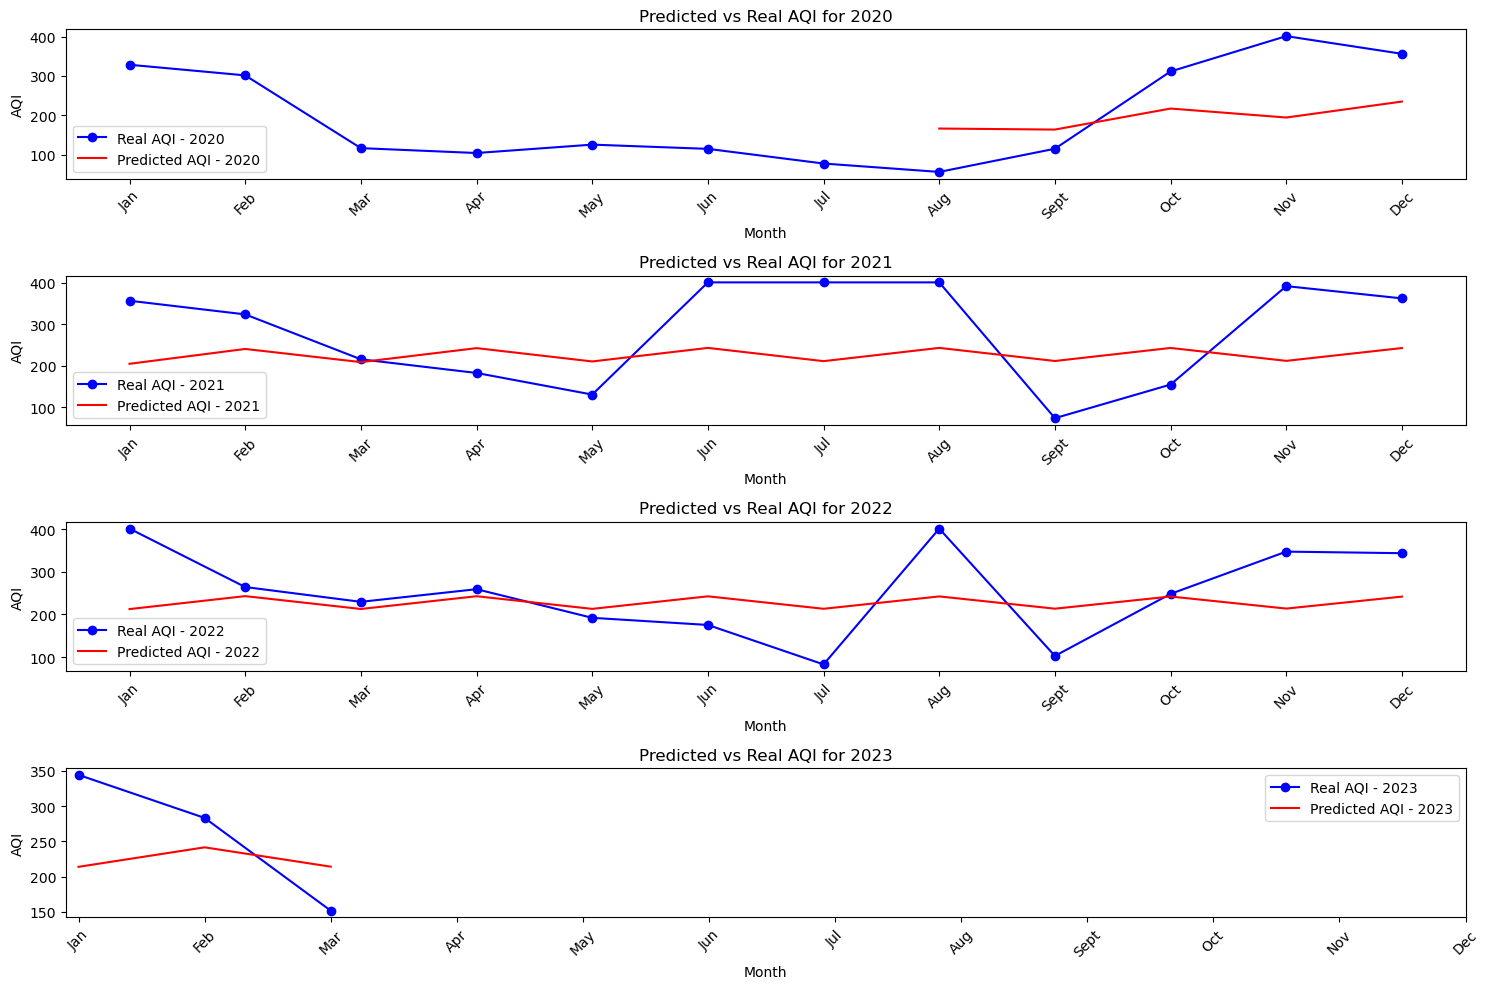

In [753]:
mdf.index = pd.to_datetime(mdf.index)

mdf['Year'] = mdf.index.year
mdf['Month'] = mdf.index.month

monthly_aqi = mdf.groupby(['Year', 'Month'])['AQI'].mean().unstack()

start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

test['Year'] = test.index.year
test['Month'] = test.index.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

years_to_plot = [2020, 2021, 2022, 2023]

plt.figure(figsize=(15, 10))

for i, year in enumerate(years_to_plot, 1):
    plt.subplot(len(years_to_plot), 1, i)
    
    if year in monthly_aqi.index:
        plt.plot(monthly_aqi.columns, monthly_aqi.loc[year], marker='o', label=f'Real AQI - {year}', color='blue')
    
    year_test = test[test['Year'] == year]
    year_pred = pred[test.index.year == year]
    
    plt.plot(year_test.index.month, year_pred, label=f'Predicted AQI - {year}', color='red')
    plt.xticks(range(1, 13), month_names, rotation=45)
    plt.title(f'Predicted vs Real AQI for {year}')
    plt.xlabel('Month')
    plt.ylabel('AQI')
    plt.legend()


plt.tight_layout()
plt.show()

<Axes: >

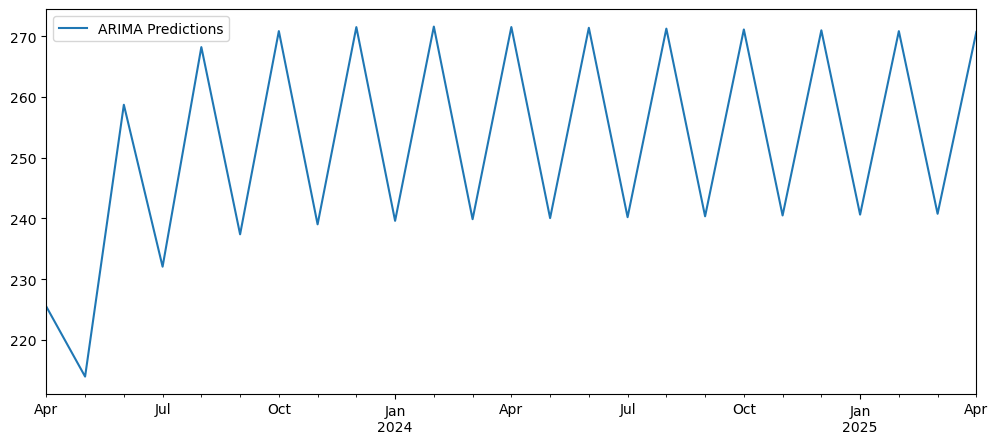

In [811]:
predicted.plot(figsize=(12,5), legend=True)

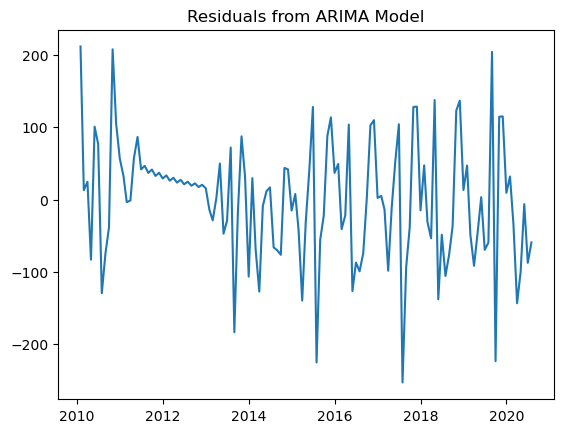

     lb_stat  lb_pvalue
10  10.87475   0.367359
Residuals are uncorrelated (p-value > 0.05).


In [821]:
#Ljung-Box test 

from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model.resid

plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box)

if ljung_box['lb_pvalue'].iloc[0] > 0.05:
    print("Residuals are uncorrelated (p-value > 0.05).")
else:
    print("Residuals are correlated (p-value <= 0.05).")

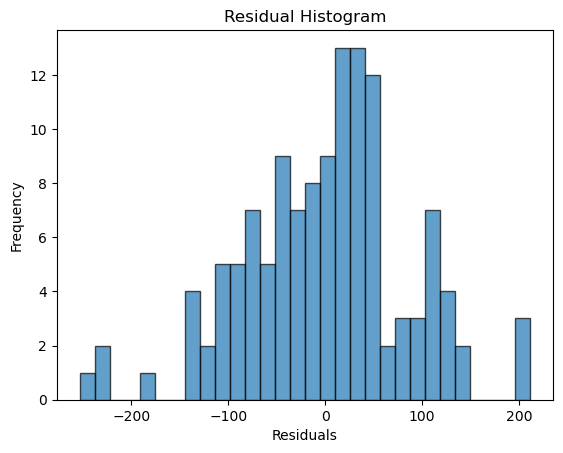

Normality Test p-value: 0.238427699183951
Residuals are likely normally distributed. Model is capturing models.


In [823]:
# Normal test 

from scipy.stats import normaltest

plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

stat, p = normaltest(residuals)  
print(f"Normality Test p-value: {p}")

if p > 0.05:
    print("Residuals are likely normally distributed. Model is capturing patterns.")
else:
    print("Residuals are not normally distributed. Model is not capturing patterns")

In [825]:
y_true = test["AQI"].values
y_pred = pred.values

mae = np.mean(np.abs(y_true - y_pred))
print(f"Mean Absolute Error (MAE): {mae}")

mse = np.mean((y_true - y_pred)**2)
print(f"Mean Squared Error (MSE): {mse}")

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


naive_forecast = np.roll(y_true, 1) 
naive_forecast[0] = np.nan

naive_mae = np.mean(np.abs(y_true[1:] - naive_forecast[1:]))
mase = mae / naive_mae
print(f"Mean Absolute Scaled Error (MASE): {mase}")

Mean Absolute Error (MAE): 99.97988906323187
Mean Squared Error (MSE): 13331.327537290248
Mean Absolute Percentage Error (MAPE): 48.57%
Mean Absolute Scaled Error (MASE): 1.0212921486246649


In [831]:
model2=ARIMA(mdf["AQI"], order=(2,1,2))
model2=model2.fit()

In [833]:
index_future_dates=pd.date_range(start="2023-03-31",end="2024-12-31")
predicted=model2.predict(start=len(mdf),end=len(mdf)+24, typ="levels").rename("ARIMA Predictions")
print(predicted)


2023-04-30    225.469007
2023-05-31    213.945976
2023-06-30    258.736044
2023-07-31    232.051845
2023-08-31    268.234468
2023-09-30    237.384479
2023-10-31    270.871769
2023-11-30    239.028481
2023-12-31    271.529189
2024-01-31    239.606617
2024-02-29    271.615950
2024-03-31    239.876098
2024-04-30    271.538892
2024-05-31    240.055541
2024-06-30    271.415463
2024-07-31    240.208071
2024-08-31    271.279562
2024-09-30    240.351919
2024-10-31    271.140967
2024-11-30    240.492358
2024-12-31    271.002493
2025-01-31    240.630918
2025-02-28    270.864945
2025-03-31    240.768048
2025-04-30    270.728546
Freq: ME, Name: ARIMA Predictions, dtype: float64
